# HOMEWORK 3: Instance Segmentation

Download the necessary libraries

In [3]:
from pathlib import Path
import cv2
import skimage.io as sio
import matplotlib.pyplot as plt
import os
import tarfile
import json
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn
from tqdm import tqdm
import skimage.io as sio
from tqdm import tqdm

In [5]:
from utils import encode_mask, decode_maskobj

Mount the google drive

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load the data and change paths HERE

In [7]:
# Define paths
archive_path = "/content/drive/MyDrive/NYCU/HW3/hw3-data-release.tar.gz"
extract_dir = "/content/drive/MyDrive/NYCU/HW3/hw3-data-release"  # target folder

# Extract only if not already extracted
if not os.path.exists(extract_dir) or len(os.listdir(extract_dir)) == 0:
    print("Extracting data...")
    os.makedirs(extract_dir, exist_ok=True)
    with tarfile.open(archive_path, "r:gz") as tar:
        tar.extractall(path=extract_dir)
    print("Extraction completed to:", extract_dir)
else:
    print("Data already extracted at:", extract_dir)

Data already extracted at: /content/drive/MyDrive/NYCU/HW3/hw3-data-release


Segmenation dataset class

In [10]:
class HW3SegmentationDataset(Dataset):
    def __init__(self, root_dir, transforms=None):
        self.root_dir = Path(root_dir)
        self.image_dirs = list(self.root_dir.glob("*"))
        self.transforms = transforms

    def __len__(self):
        return len(self.image_dirs)

    def __getitem__(self, idx):
        sample_dir = self.image_dirs[idx]
        image_path = sample_dir / 'image.tif'

        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        masks = []
        labels = []
        for class_id in range(1, 5):
            mask_path = sample_dir / f'class{class_id}.tif'
            if mask_path.exists():
                mask = sio.imread(str(mask_path))
                instance_ids = np.unique(mask)
                instance_ids = instance_ids[instance_ids != 0]

                for inst_id in instance_ids:
                    binary_mask = (mask == inst_id).astype(np.uint8)
                    masks.append(binary_mask)
                    labels.append(class_id)

        masks = np.stack(masks, axis=0) if masks else np.zeros((0, image.shape[0], image.shape[1]))
        labels = torch.tensor(labels, dtype=torch.int64)

        # Create bounding boxes from masks
        boxes = []
        for mask in masks:
            pos = np.where(mask)
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": torch.as_tensor(masks, dtype=torch.uint8),
            "image_id": torch.tensor([idx])
        }


        if self.transforms:
            image, target = self.transforms(image, target)

        image = torch.as_tensor(image / 255.0, dtype=torch.float32).permute(2, 0, 1)

        return image, target

Prepare and train dataset

In [11]:
train_dataset = HW3SegmentationDataset(extract_dir+'/train')
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

Prepare the model

In [12]:
def get_model_instance_segmentation(num_classes):
    model = maskrcnn_resnet50_fpn(pretrained=True)

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(
        in_features_mask, hidden_layer, num_classes)

    return model

model = get_model_instance_segmentation(num_classes=5)
model.cuda()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:00<00:00, 195MB/s]


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

Training Loop 

In [11]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 10
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=3, verbose=True
)

loss_list = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for images, targets in pbar:
        images = [img.cuda() for img in images]
        targets = [{k: v.cuda() for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_loss += losses.item()
        pbar.set_postfix(loss=losses.item())

    avg_loss = running_loss / len(train_loader)
    loss_list.append(avg_loss)

    print(f"Epoch {epoch+1} finished — Avg Loss: {avg_loss:.4f}")
    # Step the scheduler with average training loss
    scheduler.step(avg_loss)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1 finished — Avg Loss: 0.7856


Epoch 2 finished — Avg Loss: 0.7839


Epoch 3 finished — Avg Loss: 0.7342


Epoch 4 finished — Avg Loss: 0.7164


Epoch 5 finished — Avg Loss: 0.6516


Epoch 6 finished — Avg Loss: 0.6369


Epoch 7 finished — Avg Loss: 0.6210


Epoch 8 finished — Avg Loss: 0.6259


Epoch 9 finished — Avg Loss: 0.6229


Epoch 10 finished — Avg Loss: 0.5715


Plot the loss curve

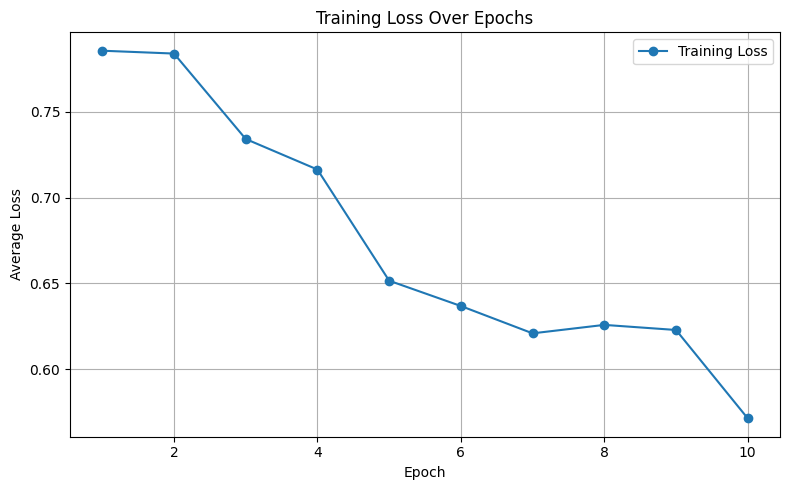

In [12]:
# Plotting the training loss after all epochs
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), loss_list, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("training_loss_plot.png")

Inference and Submission File Generation

Total test images found: 101


  0%|          | 0/101 [00:00<?, ?it/s]

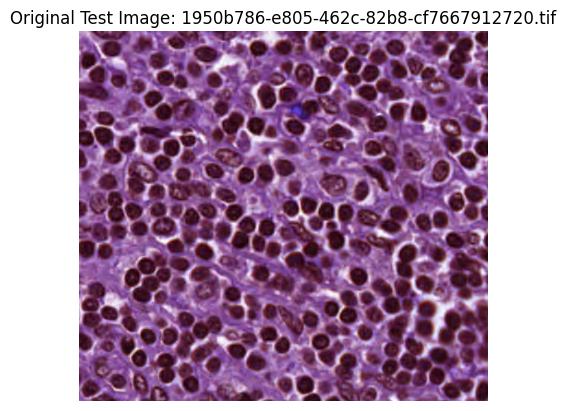

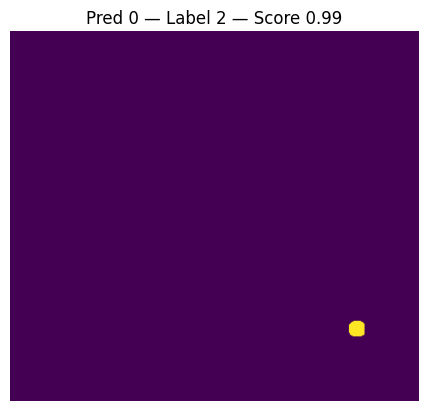

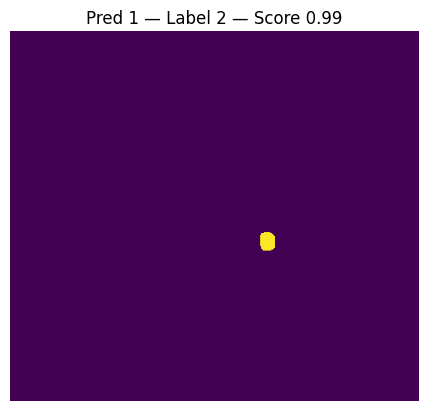

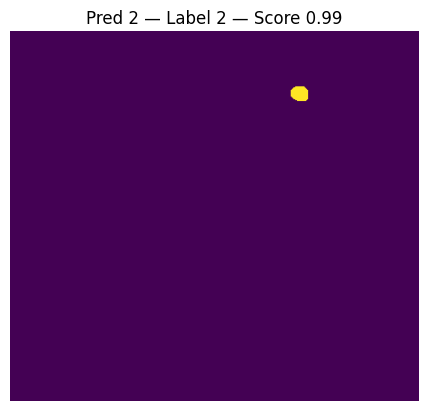

100%|██████████| 101/101 [00:23<00:00,  4.34it/s]


 Submission file saved with 5663 instances → test-results.json


In [ ]:
model.eval()
submission = []

with open(extract_dir + '/test_image_name_to_ids.json') as f:
    raw_list = json.load(f)
    name2id = {entry["file_name"]: entry["id"] for entry in raw_list}


test_dir = Path(extract_dir + '/test_release')
test_paths = list(test_dir.glob("*.tif"))

print(f"Total test images found: {len(test_paths)}")

for test_img_path in tqdm(test_paths):
    # Load image
    image = cv2.imread(str(test_img_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_tensor = torch.as_tensor(image / 255.0, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).cuda()

    # Run inference
    with torch.no_grad():
        preds = model(image_tensor)[0]

    image_id = name2id[test_img_path.name]
    num_preds = len(preds["masks"])
    #print(f"\n[{test_img_path.name}] Predictions: {num_preds}")

    for i, (mask, label, score) in enumerate(zip(preds["masks"], preds["labels"], preds["scores"])):
        score_val = float(score.item())
        #print(f"  - Instance {i}: Score = {score_val:.3f}, Label = {label.item()}")

        if score_val < 0.5:
            #print("    (Skipped due to low score)")
            continue

        binary_mask = mask[0].cpu().numpy() > 0.5
        rle = encode_mask(binary_mask)

        submission.append({
            "image_id": image_id,
            "category_id": int(label),
            "segmentation": rle,
            "score": score_val
        })

    # OPTIONAL: visualize first test image
    if test_img_path == test_paths[0]:
        plt.imshow(image)
        plt.title(f"Original Test Image: {test_img_path.name}")
        plt.axis("off")
        plt.show()

        for i in range(min(3, num_preds)):
            plt.imshow(preds["masks"][i][0].cpu().numpy() > 0.5)
            plt.title(f"Pred {i} — Label {preds['labels'][i].item()} — Score {preds['scores'][i].item():.2f}")
            plt.axis("off")
            plt.show()

# Save results
if submission:
    with open("test-results.json", "w") as f:
        json.dump(submission, f)
    print(f"\n Submission file saved with {len(submission)} instances → test-results.json")
else:
    print("\n Submission file is empty — no predictions passed the score threshold.")


In [16]:
torch.save(model.state_dict(), "best_model.pth")
print(f"Saved new best model")

Saved new best model


EXAMPLE:

In [ ]:
image_subdir = './sample_image/'
image_subdir = Path(image_subdir)

image_path = image_subdir / 'image.tif'
mask_path = image_subdir / 'class2.tif'

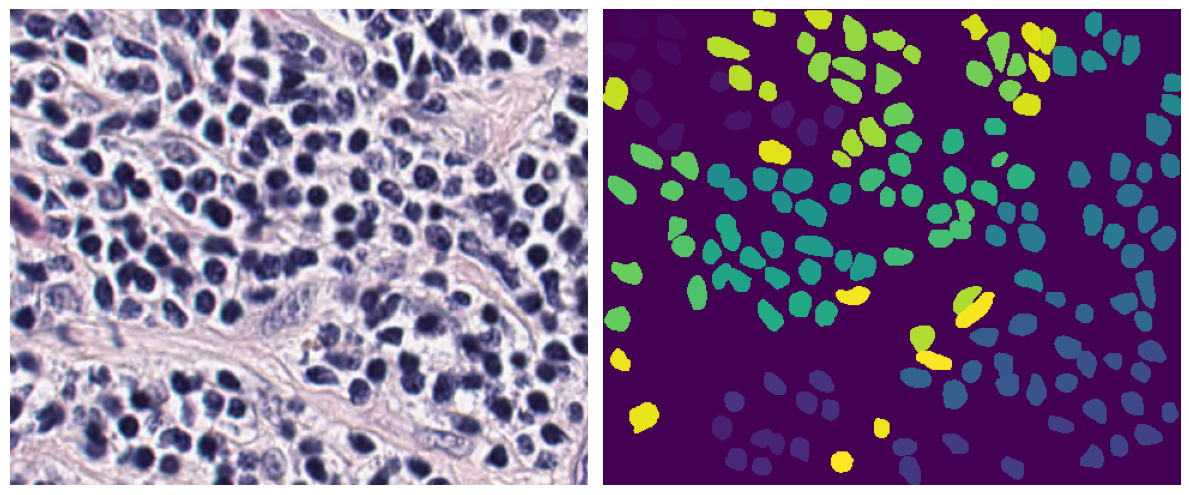

In [ ]:
image = cv2.imread(str(image_path))
mask = sio.imread(mask_path)

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(image)
plt.axis('off')

plt.subplot(122)
plt.imshow(mask)
plt.axis('off')

plt.tight_layout()
plt.show()

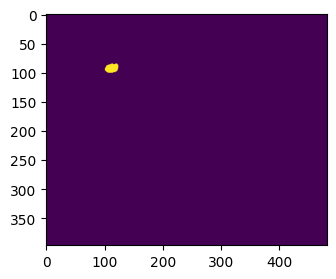

{'size': [397, 482],
 'counts': 'nWW14W<3M3N2O0O2O000O10000O100001N100000O0100O2N2LjfZ4'}

In [ ]:
# Encode a mask to RLE format -- Assume you have a predicted mask

binary_mask = mask == 10
plt.figure(figsize=(4, 3))
plt.imshow(binary_mask)
plt.show()

rle_mask = encode_mask(binary_mask=binary_mask)
rle_mask

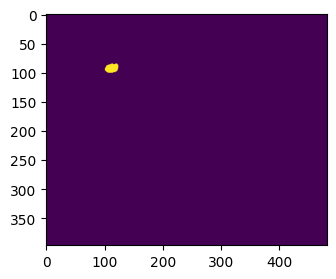

In [ ]:
# Convert it back to binark mask

decoded_mask = decode_maskobj(rle_mask)
plt.figure(figsize=(4, 3))
plt.imshow(decoded_mask)
plt.show()